<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_intro_2_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to single-cell RNA-seq II: getting started with analysis

This notebook demonstrates pre-processing and basic analysis of the [mouse retinal cells GSE126783](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126783) dataset from [Koren et al., 2019](https://doi.org/10.1016/j.immuni.2019.02.007). Following pre-processing using kallisto and bustools and basic QC, the notebook demonstrates some initial analysis. The approximate running time of the notebook is 12 minutes.

The notebook was written by Kyung Hoi (Joseph) Min, Lambda Lu, A. Sina Booeshaghi and Lior Pachter. If you use the methods in this notebook for your analysis please cite the following publications which describe the tools used in the notebook:

* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285
* McCarthy, D.J., Campbell, K.R., Lun, A.T. and Wills, Q.F. Scater: pre-processing, quality control, normalization and visualization of single-cell RNA-seq data in R (2017). doi.org/10.1093/bioinformatics/btw777


## Setup

In [0]:
# This is  used to time the running of the notebook
start_time <- Sys.time()

### Install R packages
There are several packages in R built for scRNA-seq data analysis. Here we use `SingleCellExperiment`, specifically the package `scater`. Bioconductor provides an ebook as a[comprehensive introduction to single cell data analysis](https://osca.bioconductor.org/), with code examples based on `SingleCellExperiment` some of which we have adapted for use here. 

In [3]:
system.time({
install.packages(c("BiocManager", "patchwork", "Rtsne", "uwot"), Ncpus = 2)
BiocManager::install(c("DropletUtils", "scater", "scran"), Ncpus = 2)
})

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppEigen’, ‘sitmo’, ‘FNN’, ‘RSpectra’, ‘RcppAnnoy’, ‘RcppParallel’, ‘irlba’, ‘RcppProgress’, ‘dqrng’


Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'BiocVersion', 'DropletUtils', 'scater', 'scran'

also installing the dependencies ‘formatR’, ‘zlibbioc’, ‘bitops’, ‘lambda.r’, ‘futile.options’, ‘XVector’, ‘RCurl’, ‘GenomeInfoDbData’, ‘futile.logger’, ‘snow’, ‘locfit’, ‘IRanges’, ‘R.oo’, ‘R.methodsS3’, ‘GenomicRanges’, ‘Biobase’, ‘GenomeInfoDb’, ‘beeswarm’, ‘vipor’, ‘matrixStats’, ‘gridExtra’, ‘RcppHNSW’, ‘rsvd’, ‘SingleCellExperiment’, ‘S4Vectors’, ‘BiocParallel’, ‘edgeR’, ‘rhdf5’, ‘HDF5Array’, ‘R.utils’, ‘beachmat’, ‘Rhdf5lib’, ‘BiocGenerics’, ‘SummarizedExperiment’, ‘ggbeeswarm’, ‘DelayedArray’, ‘DelayedMatrixStats’, ‘viridis’, ‘BiocNeighbors’, ‘BiocSingular’, ‘limma’, ‘igraph’, ‘statmod’


Old packages: 'curl', 'DT', 'fa

    user   system  elapsed 
2249.958  175.986 1419.100 

In [4]:
library(DropletUtils)
library(Matrix)
library(scater)
library(scran)
library(tidyverse)
library(patchwork)
theme_set(theme_bw())

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tap

In [0]:
# Slightly modified from BUSpaRse, just to avoid installing a few dependencies not used here
read_count_output <- function(dir, name) {
  dir <- normalizePath(dir, mustWork = TRUE)
  m <- readMM(paste0(dir, "/", name, ".mtx"))
  m <- Matrix::t(m)
  m <- as(m, "dgCMatrix")
  # The matrix read has cells in rows
  ge <- ".genes.txt"
  genes <- readLines(file(paste0(dir, "/", name, ge)))
  barcodes <- readLines(file(paste0(dir, "/", name, ".barcodes.txt")))
  colnames(m) <- barcodes
  rownames(m) <- genes
  return(m)
}

### Install kb-python

In [0]:
system("pip3 install kb-python")

### Download the data

In [0]:
download.file("https://caltech.box.com/shared/static/w9ww8et5o029s2e3usjzpbq8lpot29rh.gz", 
destfile = "SRR8599150_S1_L001_R1_001.fastq.gz")
download.file("https://caltech.box.com/shared/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz",
destfile = "SRR8599150_S1_L001_R2_001.fastq.gz")

Download an index

In [0]:
system("kb ref -d mouse -i index.idx -g t2g.txt")

## Pseudoalignment and counting

### Run kallisto and bustools

The following command will generate an RNA count matrix of cells (rows) by genes (columns) in H5AD format, which is a binary format used to store [Anndata](https://anndata.readthedocs.io/en/stable/) objects. Notice that this requires providing the index and transcript-to-gene mapping downloaded in the previous step to the `-i` and `-g` arguments respectively. Also, since the reads were generated with the 10x Genomics Chromium Single Cell v2 Chemistry, the `-x 10xv2` argument is used. To view other supported technologies, run `kb --list`.

In [0]:
system("kb count -i index.idx -g t2g.txt -x 10xv2 -t2 -o . SRR8599150_S1_L001_R1_001.fastq.gz SRR8599150_S1_L001_R2_001.fastq.gz")

In [10]:
list.files(".", recursive = TRUE)

[1] "10xv2_whitelist.txt"                         
 [2] "counts_unfiltered/cells_x_genes.barcodes.txt"
 [3] "counts_unfiltered/cells_x_genes.genes.txt"   
 [4] "counts_unfiltered/cells_x_genes.mtx"         
 [5] "index.idx"                                   
 [6] "inspect.json"                                
 [7] "matrix.ec"                                   
 [8] "output.bus"                                  
 [9] "output.unfiltered.bus"                       
[10] "run_info.json"                               
[11] "sample_data/anscombe.json"                   
[12] "sample_data/california_housing_test.csv"     
[13] "sample_data/california_housing_train.csv"    
[14] "sample_data/mnist_test.csv"                  
[15] "sample_data/mnist_train_small.csv"           
[16] "sample_data/README.md"                       
[17] "SRR8599150_S1_L001_R1_001.fastq.gz"          
[18] "SRR8599150_S1_L001_R2_001.fastq.gz"          
[19] "t2g.txt"                                     
[20] "transcripts.txt"

In [0]:
# Read matrix into R
res_mat <- read_count_output("counts_unfiltered", name = "cells_x_genes")

# Remove empty droplets

Most barcodes in the matrix are empty droplets, to reduce the chance that more than one cells end up in the same droplet. A common way to determine which barcodes are empty droplets and which are real cells is to plot rank of total UMI counts of each barcode against the total UMI count itself, which is commonly called knee plot. The inflection point in that plot, signifying a change in state, is used as a cutoff for total UMI counts; barcodes below that cutoff are deemed empty droplets and removed. 

In [12]:
dim(res_mat)

[1] 55421 96775

In [13]:
tot_counts <- Matrix::colSums(res_mat)
summary(tot_counts)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    1.00   25.74    3.00 2753.00 

In [0]:
bc_rank <- barcodeRanks(res_mat, lower = 10)

In [0]:
#' Knee plot for filtering empty droplets
#' 
#' Visualizes the inflection point to filter empty droplets. This function plots 
#' different datasets with a different color. Facets can be added after calling
#' this function with `facet_*` functions. Will be added to the next release
#' version of BUSpaRse.
#' 
#' @param bc_rank A `DataFrame` output from `DropletUtil::barcodeRanks`.
#' @return A ggplot2 object.
knee_plot <- function(bc_rank) {
  knee_plt <- tibble(rank = bc_rank[["rank"]],
                     total = bc_rank[["total"]]) %>% 
    distinct() %>% 
    dplyr::filter(total > 0)
  annot <- tibble(inflection = metadata(bc_rank)[["inflection"]],
                  rank_cutoff = max(bc_rank$rank[bc_rank$total > metadata(bc_rank)[["inflection"]]]))
  p <- ggplot(knee_plt, aes(total, rank)) +
    geom_line() +
    geom_hline(aes(yintercept = rank_cutoff), data = annot, linetype = 2) +
    geom_vline(aes(xintercept = inflection), data = annot, linetype = 2) +
    scale_x_log10() +
    scale_y_log10() +
    annotation_logticks() +
    labs(y = "Rank", x = "Total UMIs")
  return(p)
}

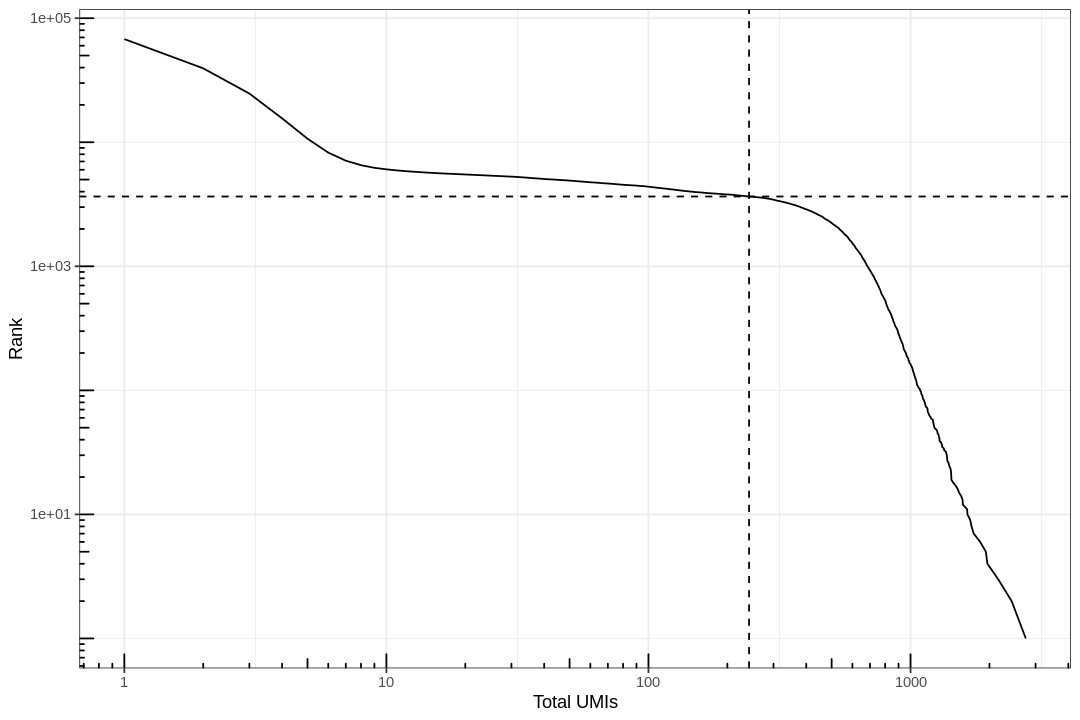

In [16]:
options(repr.plot.width=9, repr.plot.height=6)
knee_plot(bc_rank)

In [17]:
res_mat <- res_mat[, tot_counts > metadata(bc_rank)$inflection]
res_mat <- res_mat[Matrix::rowSums(res_mat) > 0,]
dim(res_mat)

[1] 21574  3655

# QC

Percentage of transcripts from mitochondrially encoded genes

In [18]:
tr2g <- read_tsv("t2g.txt", col_names = c("transcript", "gene", "gene_symbol")) %>%
  select(-transcript) %>%
  distinct()

Parsed with column specification:
cols(
  transcript = col_character(),
  gene = col_character(),
  gene_symbol = col_character()
)



In [0]:
# Which genes are mitochondrial
mt_inds <- which(rownames(res_mat) %in% tr2g$gene[str_detect(tr2g$gene_symbol, "^mt-")])

In [20]:
sce <- SingleCellExperiment(assays = list(counts = res_mat))
sce <- logNormCounts(sce)
df <- perCellQCMetrics(sce, subsets = list(Mito = mt_inds))
colData(sce) <- cbind(colData(sce), df)
colData(sce)

DataFrame with 3655 rows and 10 columns
                       sum  detected   percent_top_50  percent_top_100
                 <numeric> <integer>        <numeric>        <numeric>
AAACCTGAGACGCAAC      1093       626 38.7008234217749 49.4053064958829
AAACCTGCAGACGCCT       764       493 37.9581151832461 48.5602094240838
AAACCTGGTAGAGTGC       261       189 46.7432950191571 65.9003831417624
AAACCTGTCGATGAGG       676       413  43.491124260355  53.698224852071
AAACGGGAGATCACGG       512       318         46.09375        57.421875
...                    ...       ...              ...              ...
TTTGTCAAGCCACGCT       548       352 42.5182481751825  54.014598540146
TTTGTCAAGCTAGTTC       362       258 42.5414364640884  56.353591160221
TTTGTCACAGCTGTTA       737       483 36.9063772048847 48.0325644504749
TTTGTCAGTATAGGGC       686       328 56.4139941690962 66.7638483965015
TTTGTCATCGCGTAGC       628       356 49.5222929936306 59.2356687898089
                  percent_top_200  pe

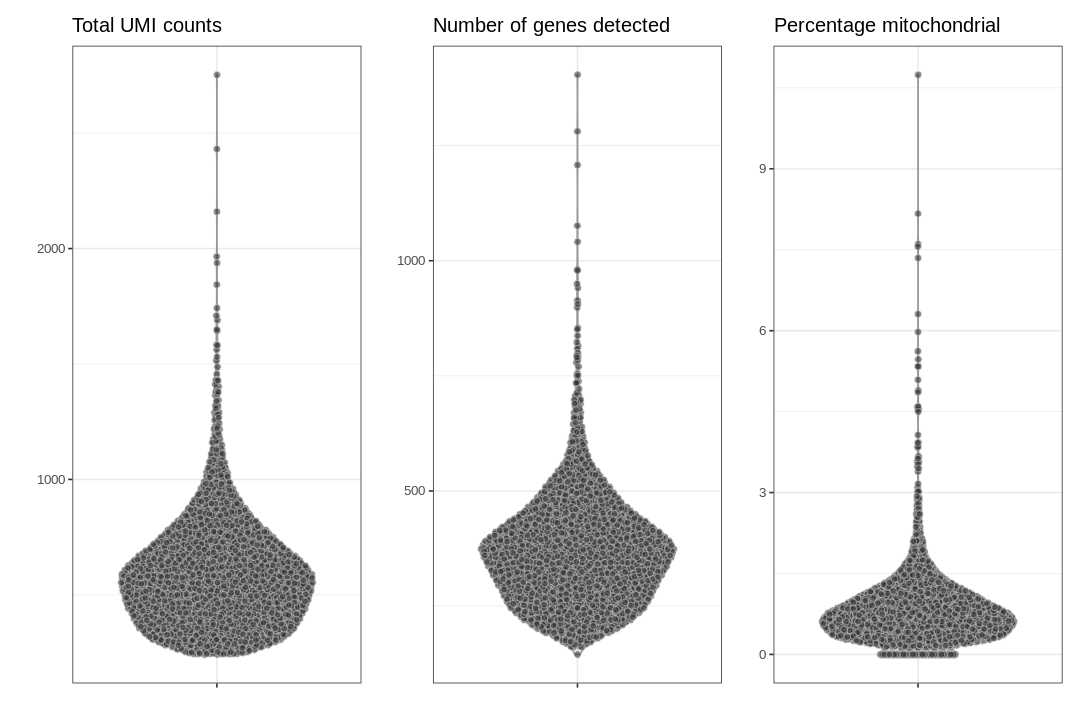

In [21]:
p1 <- plotColData(sce, "sum") + labs(y = "", title = "Total UMI counts")
p2 <- plotColData(sce, "detected") + labs(y = "", title = "Number of genes detected")
p3 <- plotColData(sce, "subsets_Mito_percent") + labs(y = "", title = "Percentage mitochondrial")
p1 + p2 + p3

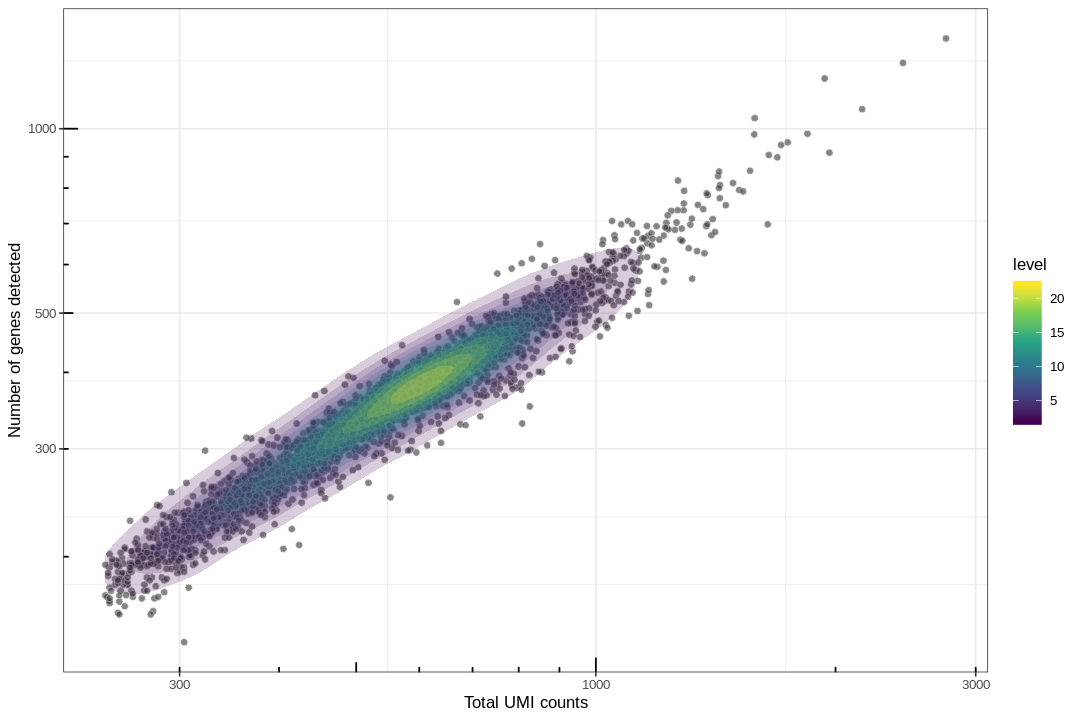

In [22]:
plotColData(sce, x = "sum", y = "detected") +
  stat_density_2d(aes(fill = stat(level)), geom = "polygon", alpha = 0.2) +
  scale_fill_viridis_c() +
  scale_x_log10() +
  scale_y_log10() +
  annotation_logticks() +
  labs(x = "Total UMI counts", y = "Number of genes detected")

The color shows density of points, as the density is not apparent when many points are stacked on top of each other. Cells with high percentage of mitochondrially encoded transcripts are often removed in QC, as those are likely to be low quality cells. If a cell lysed in sample preparation, transcripts in the mitochondria are less likely to be lost than transcripts in the cytoplasm due to the double membrane of the mitochondria, so cells that lysed tend to have higher percentage of mitochondrially encoded transcripts.

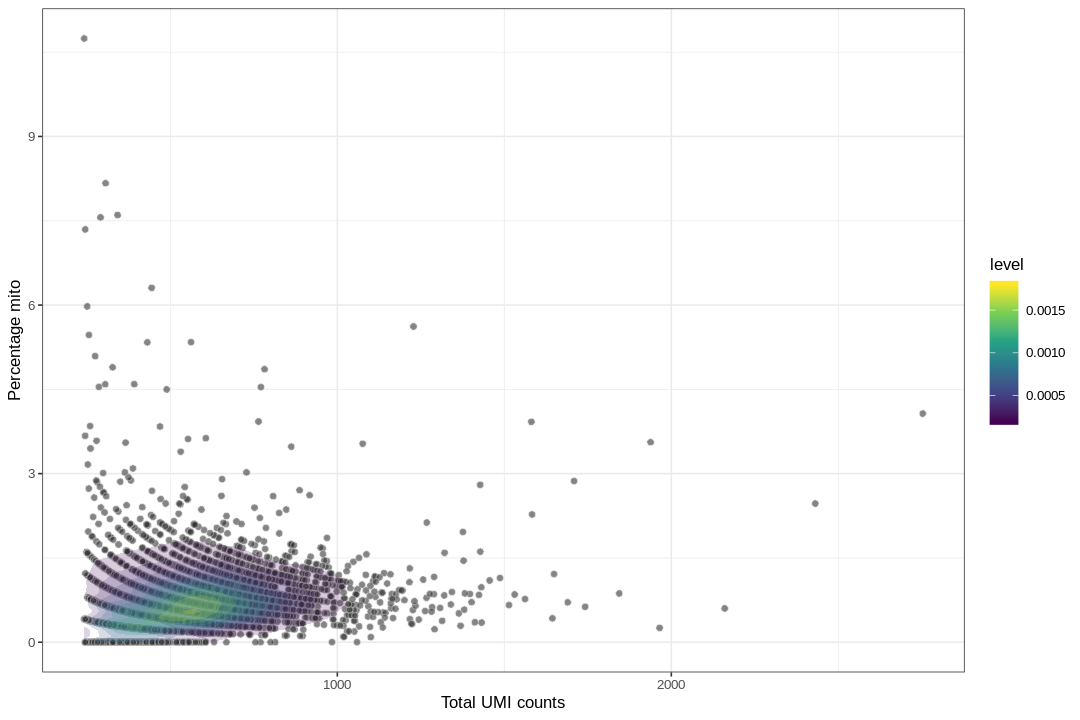

In [23]:
plotColData(sce, x = "sum", y = "subsets_Mito_percent") +
  stat_density_2d(aes(fill = stat(level)), geom = "polygon", alpha = 0.2) +
  scale_fill_viridis_c() +
  labs(x = "Total UMI counts", y = "Percentage mito")

From the plot, it seems that 3% is a decent cutoff.

In [0]:
sce <- sce[, sce$subsets_Mito_percent < 3]

# Dimension reduction
## Get highly variable genes

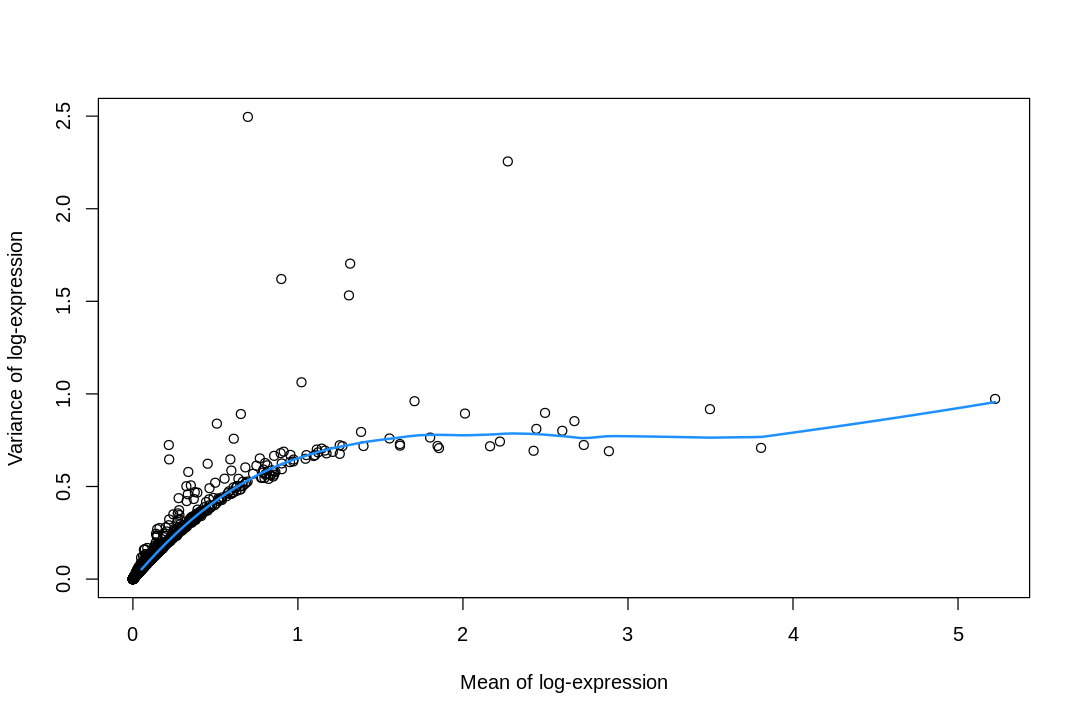

In [25]:
dec_sce <- modelGeneVar(sce)
fit_pbmc <- metadata(dec_sce)
# Adapted from https://osca.bioconductor.org/feature-selection.html#feature-selection
plot(fit_pbmc$mean, fit_pbmc$var, xlab="Mean of log-expression",
    ylab="Variance of log-expression")
curve(fit_pbmc$trend(x), col="dodgerblue", add=TRUE, lwd=2)

In [0]:
# Run PCA on highly variable genes
hvgs <- getTopHVGs(dec_sce, n = 3000)
sce <- runPCA(sce, subset_row = hvgs)

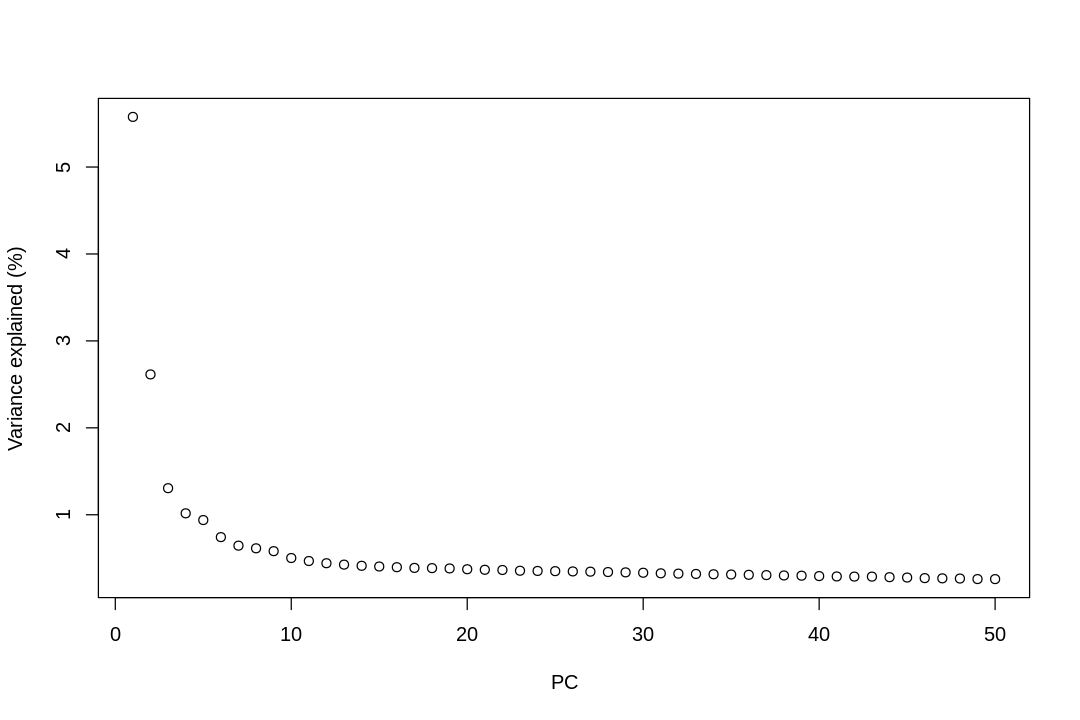

In [27]:
# Percentage of variance explained is tucked away in the attributes.
percent.var <- attr(reducedDim(sce), "percentVar")
plot(percent.var, xlab="PC", ylab="Variance explained (%)")

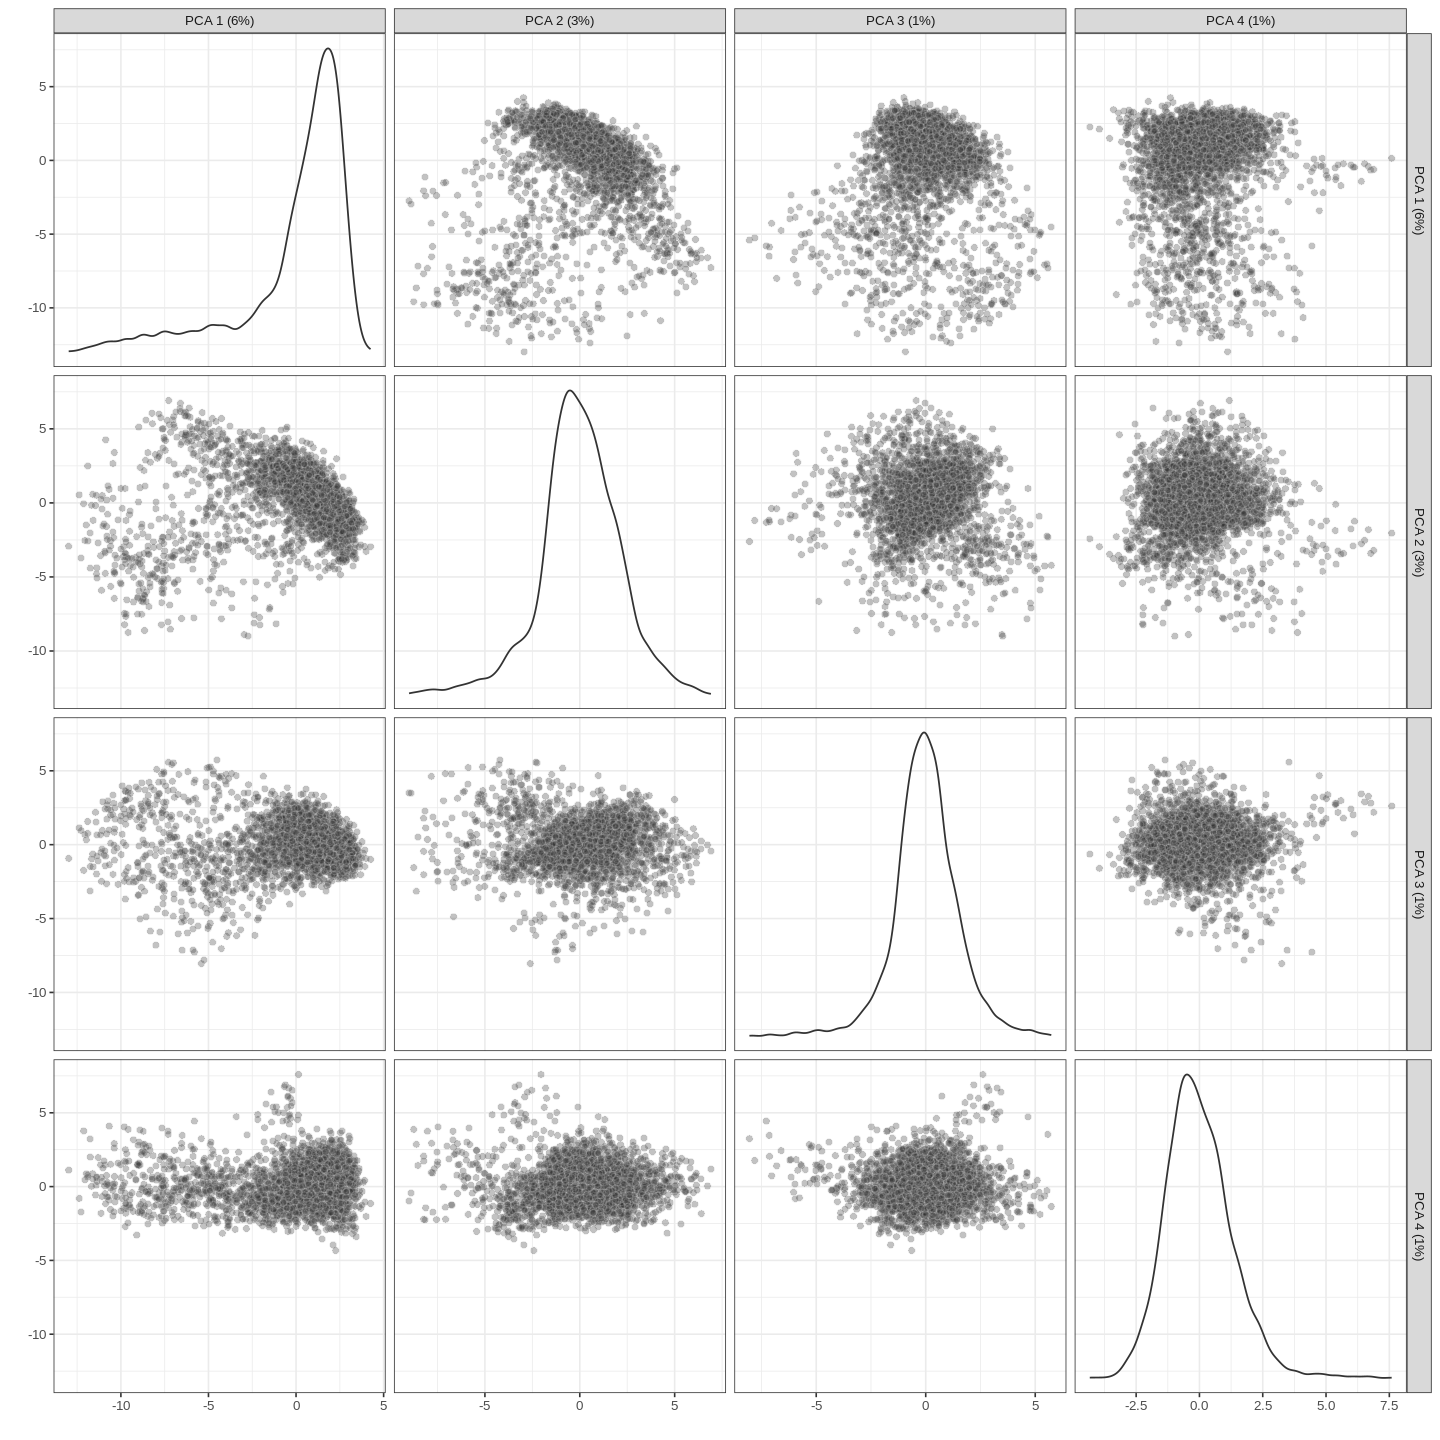

In [28]:
options(repr.plot.width=12, repr.plot.height=12)
plotPCA(sce, ncomponents = 4, point_alpha = 0.3)

In [0]:
g <- buildSNNGraph(sce, k = 15, use.dimred = "PCA")
sce$cluster <- igraph::cluster_louvain(g)$membership %>% factor()

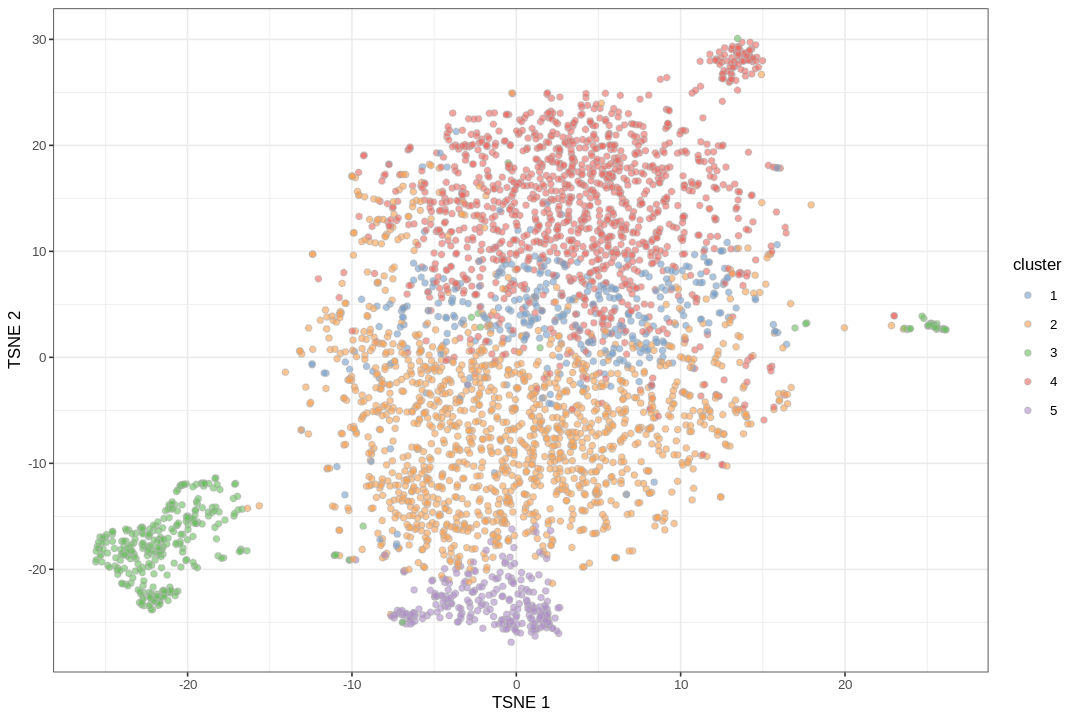

In [30]:
options(repr.plot.width=9, repr.plot.height=6)
sce <- runTSNE(sce, dimred = "PCA", n_dimred = 15)
plotTSNE(sce, colour_by = "cluster")

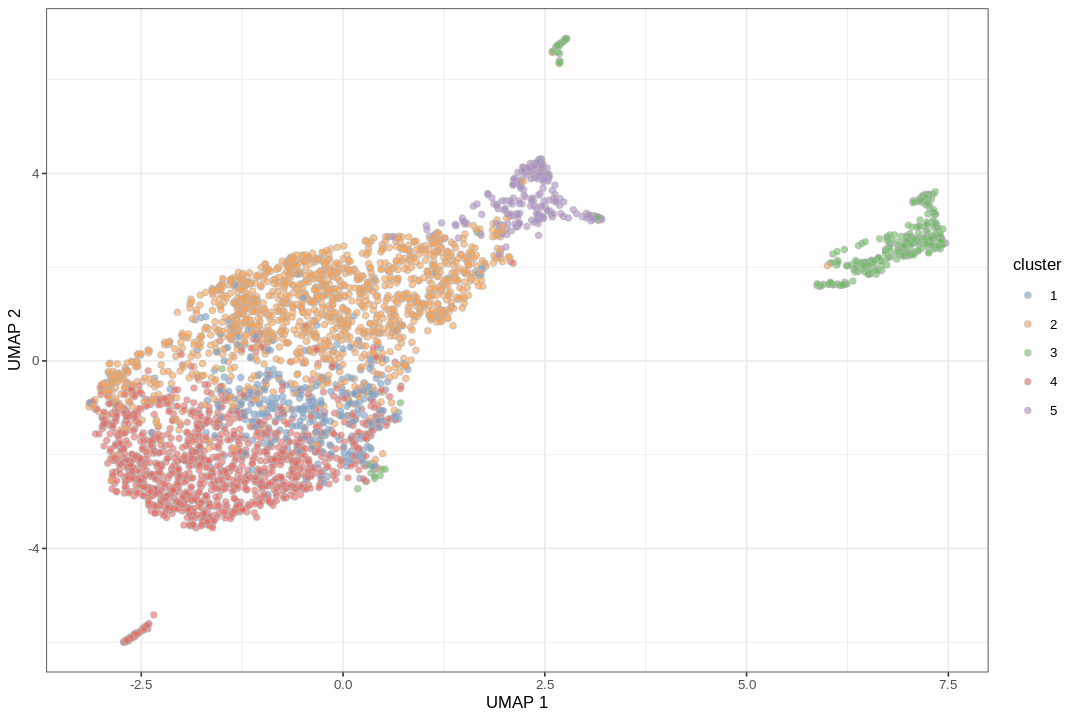

In [31]:
set.seed(1)
sce <- runUMAP(sce, dimred = "PCA", n_neighbors = 30, n_dimred = 15)
plotUMAP(sce, colour_by = "cluster")

In [32]:
Sys.time() - start_time

Time difference of 30.49327 mins

Installing packages took about 26 minutes (the dark side of Rcpp, but in practice, we usually only install packages once for the entire project, or have the same packages shared across projects, not installing packages anew for each notebook, so I don't think this is really terrible news), so all this analysis took only about 10 minutes, from downloading fastqs to clustering and UMAP.